<a href="https://colab.research.google.com/github/NishaMDev/DeepLearning/blob/main/Assignment%231/DL_Assignment_1_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART B**

Whitebox deep learning - Read and perform the codelab https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist#0 (Links to an external site.)

### Parameters

In [ ]:
# 11 - Decrease batch size to 64
#BATCH_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [ ]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


**This cell contains helper functions used for visualization and downloads only. You can skip reading it. There is very little useful Keras/Tensorflow code here.**


In [ ]:
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

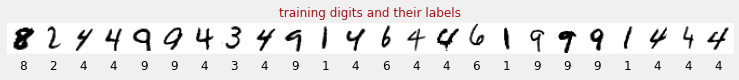

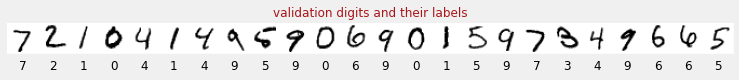

In [ ]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [ ]:
# 9 - Add Convolution layer
#model = tf.keras.Sequential(
#  [
#      tf.keras.layers.Input(shape=(28*28,)),
# 1 - Add layers with Dense Layer with sigmoid activation   
# 2 - Replace all activation='sigmoid' with activation='relu' in your layers and train again.   
#      tf.keras.layers.Dense(200, activation='sigmoid'),
#      tf.keras.layers.Dense(60, activation='sigmoid'),
#      tf.keras.layers.Dense(200, activation='relu'),
# 8 - add dropout layer 
#      tf.keras.layers.Dropout(0.25),   
# 7 - add 4 dense layer 
#      tf.keras.layers.Dense(100, activation='relu'), 
#      tf.keras.layers.Dropout(0.25),  
#      tf.keras.layers.Dense(60, activation='relu'),
#      tf.keras.layers.Dropout(0.25),
#      tf.keras.layers.Dense(10, activation='softmax')
#  ])

# 9 - Add convolution layer.
#model = tf.keras.Sequential([
#    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
#    tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu'),
#    tf.keras.layers.Conv2D(kernel_size=6, filters=24, strides=2, activation='relu'),
#    tf.keras.layers.Conv2D(kernel_size=6, filters=32, strides=2, activation='relu'),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(200, activation='relu'),
# 10 - Add dropout layer with dropout rate of 40% between Dense layer
#    tf.keras.layers.Dropout(0.4),
#    tf.keras.layers.Dense(10, activation='softmax')
#])

# 11 - Add Batch Norm layer
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

# 3 - Replace the 'sgd' optimizer with a better one, for example 'adam' and train again.
# model.compile(optimizer='sgd',
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)

# 4 - Increase the learning rate from its default value of 0.001 to 0.01. For that, you will have to replace the 'adam' predefined optimizer with an actual instance of an Adam optimizer so that you have access to its configuration parameters
model.compile(optimizer=optimizer,       
#model.compile(optimizer='adam',         
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
# 4 increase the zoom rate from 1 to 5.
#plot_training = PlotTraining(sample_rate=10, zoom=1)

# 7 - Increase zoom from 5 to 10
#plot_training = PlotTraining(sample_rate=10, zoom=5)
# 11 - Increase zoom from 10 to 16
plot_training = PlotTraining(sample_rate=10, zoom=16)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 12)        108       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 12)       36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 12)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 24)        10368     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 24)       72        
 hNormalization)                                        

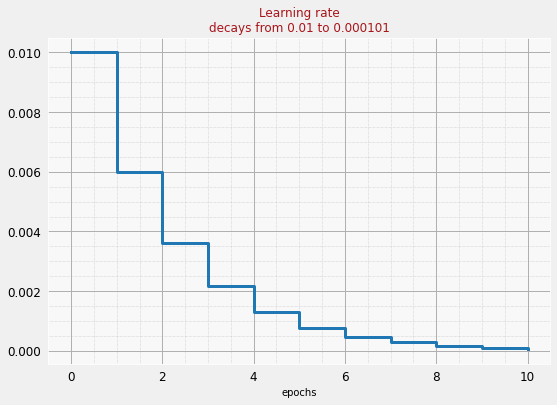

In [ ]:
#6 - Implement a learning rate schedule that decays the learning rate exponentially. 

# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Train and validate the model

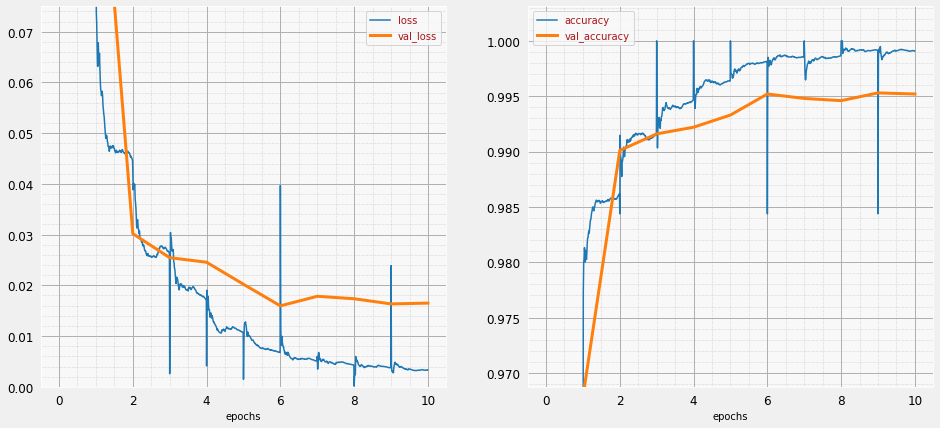

937/937 [==============================] - 9s 10ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0165 - val_accuracy: 0.9952 - lr: 1.0078e-04


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback ])  # 6 - Add lr_decay_callback to the callbacks

### Visualize predictions

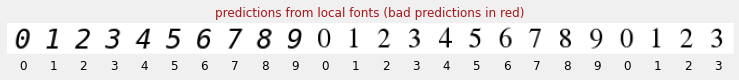

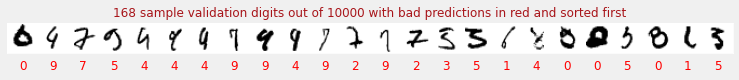

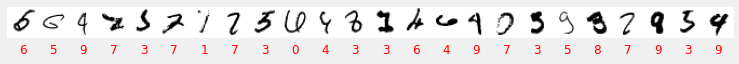

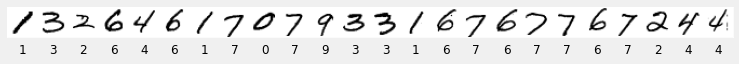

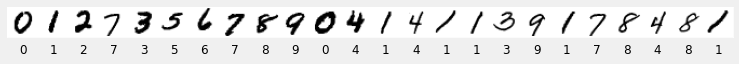

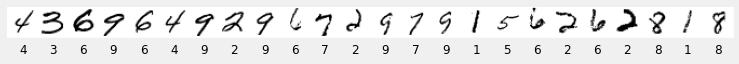

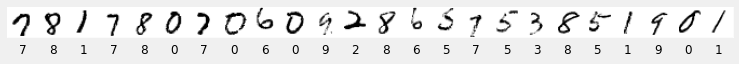

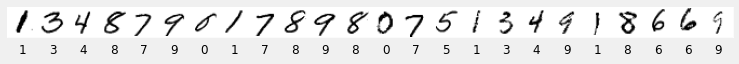

In [ ]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose


**As part of STEP 14, train the model in Google Cloud Platform**

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.7.0'

Install Tensorflow Cloud

In [ ]:
! pip install -q tensorflow-cloud

import tensorflow_cloud as tfc
tfc.__version__

     |████████████████████████████████| 92 kB 408 kB/s 
     |████████████████████████████████| 98 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 45.2 MB/s 
     |████████████████████████████████| 427 kB 32.2 MB/s 
     |████████████████████████████████| 53 kB 866 kB/s 
     |████████████████████████████████| 19.1 MB 9.2 MB/s 
     |████████████████████████████████| 23.6 MB 13.3 MB/s 
     |████████████████████████████████| 10.1 MB 30.5 MB/s 
     |████████████████████████████████| 508 kB 38.9 MB/s 
     |████████████████████████████████| 2.3 MB 33.9 MB/s 
     |████████████████████████████████| 245 kB 37.1 MB/s 
     |████████████████████████████████| 151 kB 37.3 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
     |████████████████████████████████| 63 kB 712 kB/s 
     |████████████████████████████████| 172 kB 11.7 MB/s 
     |████████████████████████████████| 255 kB 35.1 MB/s 
     |████████████████████████████████| 111 kB 42.0 MB/s 
     |████████████████

'0.1.16'

# **Train locally**

**Train the task1.py locally**

In [3]:
!gcloud ai-platform local train --module-name trainer.task1 --package-path trainer

Tensorflow version 2.7.0
2022-02-10 20:41:55.336855: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-02-10 20:41:57.109576: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-10 20:41:58.459777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dat

# **Train in the cloud**

**To obtain new credentials.**


In [4]:
!gcloud auth login


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=AODGSnYae95EHHcUD1D69iQRY4JtzI&prompt=consent&access_type=offline&code_challenge=_kfh0iMaTz3fRn53i-paa628rzAj1aU5WFnIX1nMJvQ&code_challenge_method=S256

Enter verification code: 4/1AX4XfWh79DNN90S8TEvs_v9EPMCaHmUfhzaKZNzq5_1I0OmliXig4SNVqr0

You are now logged in as [nishamohan.devadiga@sjsu.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


**Set the Project ID.**

In [5]:
!gcloud config set project dlassignment12

Updated property [core/project].


**Set the Compute / Region**




In [8]:
!gcloud config set compute/region us-central1

Updated property [compute/region].


Submit the job on Google Cloud Platform 

In [12]:
!gcloud ai-platform jobs submit training jobX11 --job-dir gs://dlassignment12/jobs/jobX11 --project dlassignment12 --config config.yaml --module-name trainer.task1 --package-path trainer --runtime-version 2.6 --python-version 3.7

Job [jobX11] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe jobX11

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs jobX11
jobId: jobX11
state: QUEUED


**To view the status of the job**

In [13]:
!gcloud ai-platform jobs describe jobX11

createTime: '2022-02-10T21:01:12Z'
etag: mYVqTvd_AeM=
jobId: jobX11
jobPosition: '0'
state: PREPARING
trainingInput:
  jobDir: gs://dlassignment12/jobs/jobX11
  packageUris:
  - gs://dlassignment12/jobs/jobX11/packages/418245e499d4dd93a5636ddc542662f50c7597d8ec75146f8b5586211a6618cf/trainer-0.0.0.tar.gz
  pythonModule: trainer.task1
  pythonVersion: '3.7'
  region: us-central1
  runtimeVersion: '2.6'
  scaleTier: BASIC_GPU
trainingOutput: {}

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/jobX11?project=dlassignment12

View logs at:
https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2FjobX11&project=dlassignment12


**Job Status in GCP:**

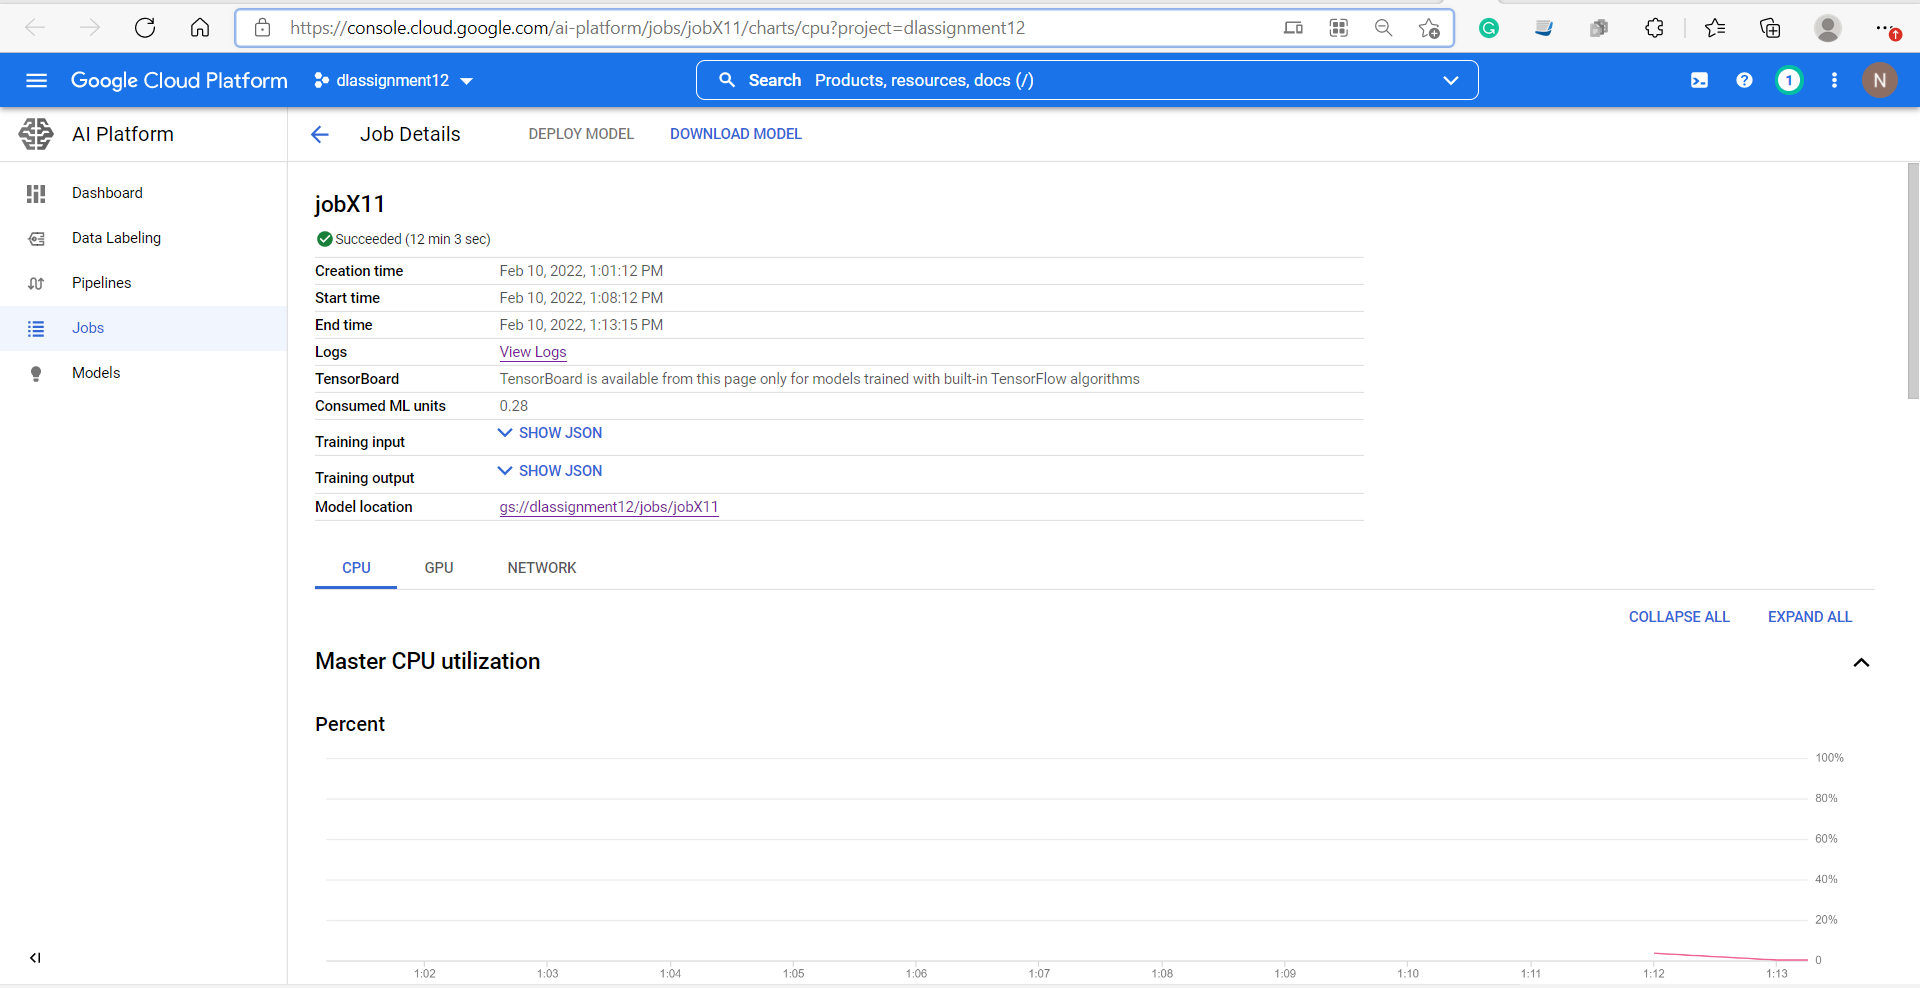

**Job Logs:**

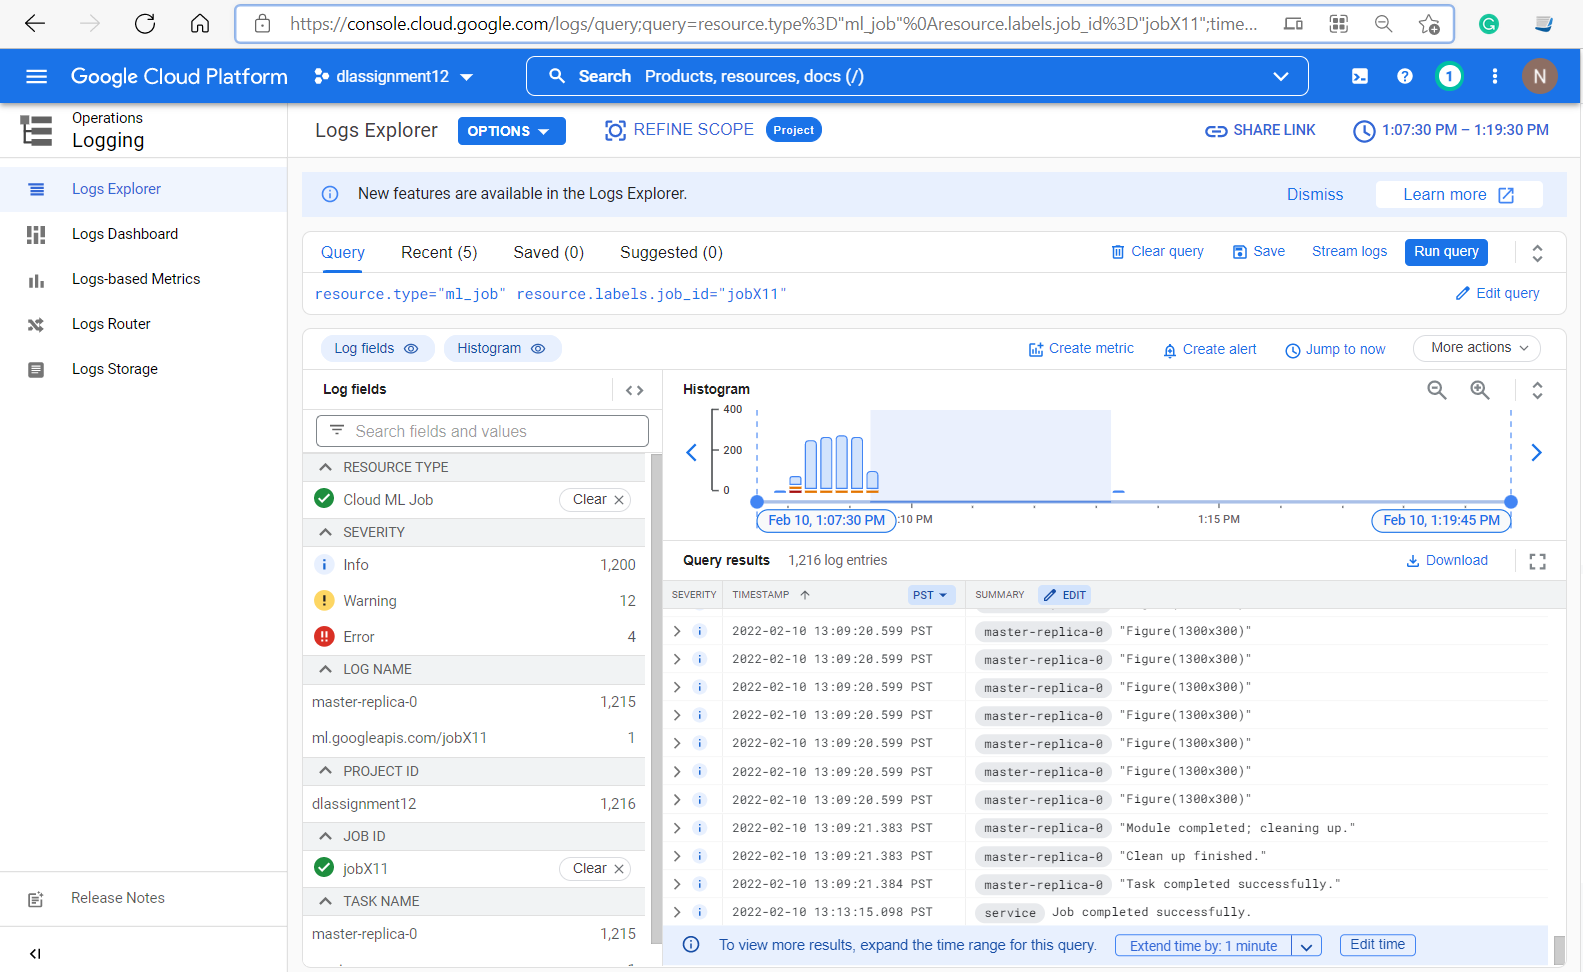

**`Model Location:`** - gs://dlassignment12/jobs/jobX11

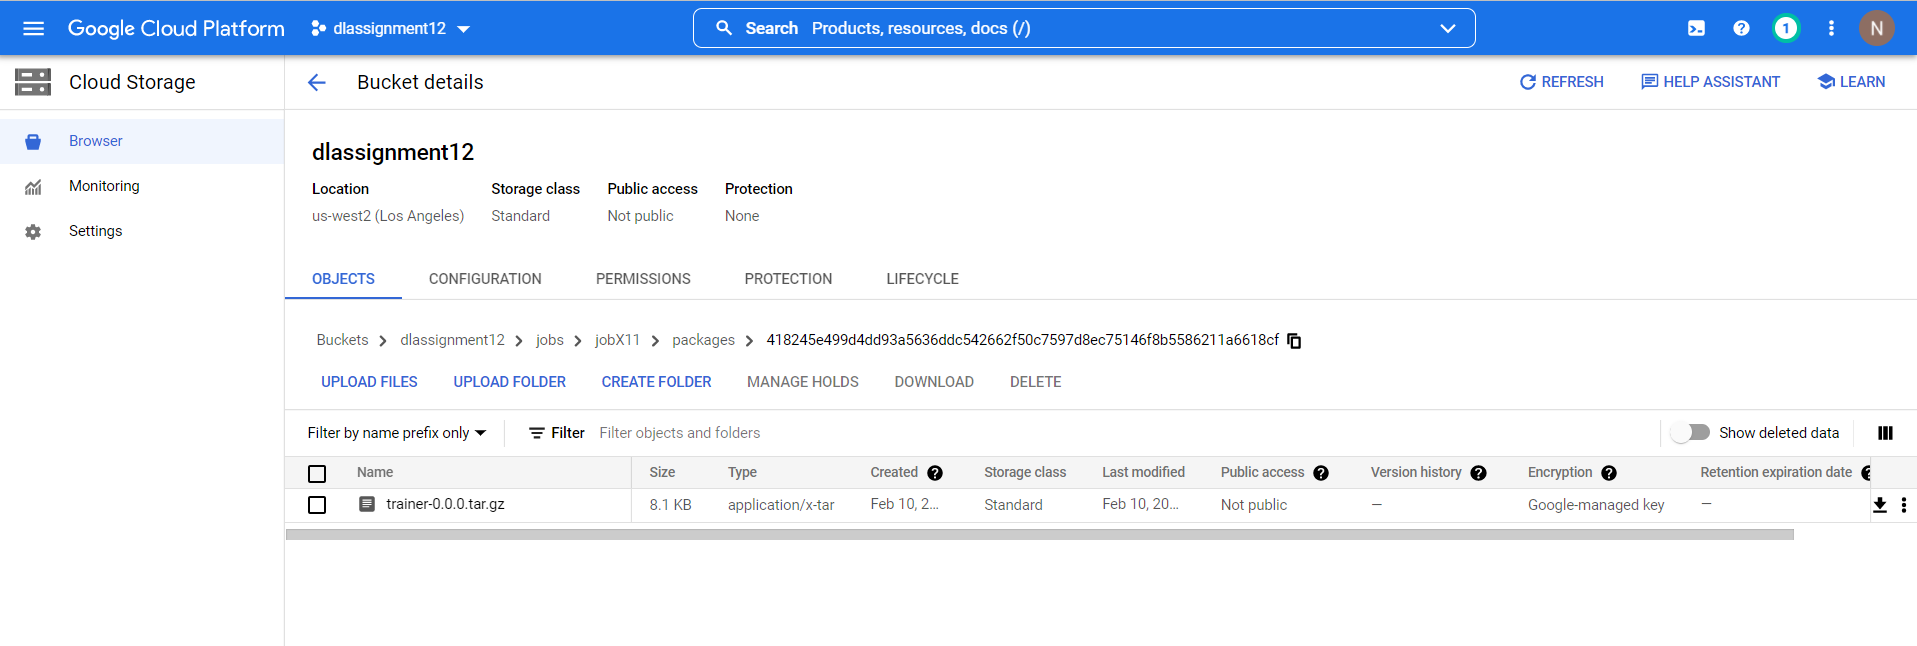